# Structural estimation demo

Estimate payoff parameters from simulated data.


Negative LL at true α: 826.9851326771178
 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 826.7925193066527
       x: -1.5349275887950564
     nit: 14
    nfev: 17
True α₁₀ = -1.5,  MLE = -1.535


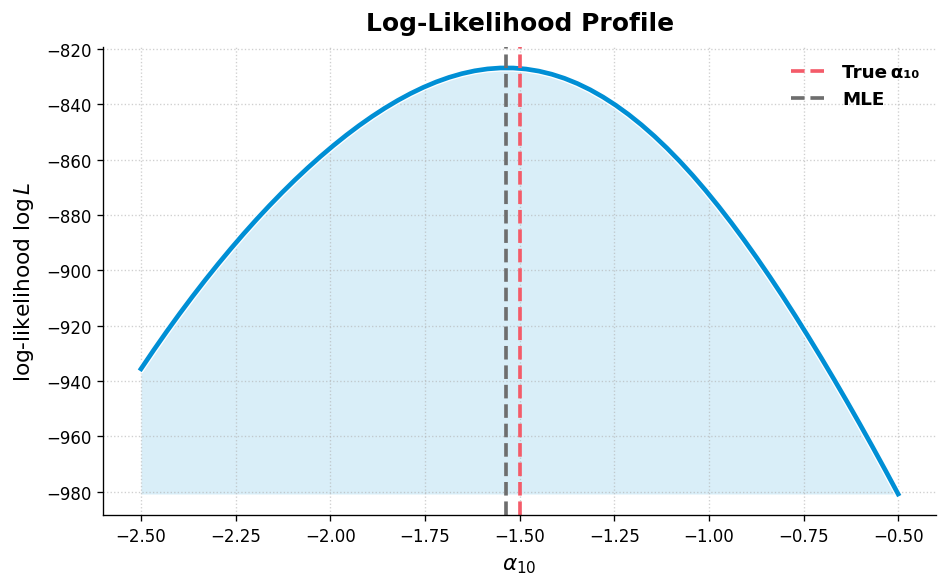

In [1]:
# %%
# 03_structural_estimation.py
#
# Very small‑scale MLE example: estimate a single payoff intercept
# holding all other parameters fixed, using simulated data.

# Author: Mirko De Maria (July 2025)
# m.de-maria@imperial.ac.uk
# mirkodemaria.com
"""
# 03 Structural Estimation Demo *(one-parameter MLE)*

Goal: show how to take the toolkit's CCP / likelihood machinery and
embed it in an optimisation routine.

We:  
1. Fix all payoff parameters except Firm 1's intercept `α₁₀`.  
2. Simulate 1,000 markets under the *true* α₁₀ = -1.5.  
3. Maximise the log-likelihood over α₁₀ using `scipy.optimize`.  
4. Compare the MLE to the truth and plot the likelihood curve.
"""
# %%
import sys, pathlib, os
# Path to the *src* directory that contains some packages
root = pathlib.Path().resolve()          
src_path = root.parent / "src"        
sys.path.append(str(src_path))
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from discrete_game_identification import (
    solve_equilibrium,
    compute_joint_distribution,
)

plt.rcParams["figure.figsize"] = (6,4)
rng = np.random.default_rng(0)

# %% 1  Model skeleton (everything fixed except alpha10)
nplayers, num_z, num_kappa = 2, 3, 1
zvals = np.linspace(0,1,num_z)
beta = np.zeros((nplayers, nplayers, num_z, num_kappa))
beta[0,1] = -3.5
beta[1,0] = -2.5
alpha_fixed = np.zeros((nplayers, num_z, num_kappa))
alpha_fixed[1,:,0] = -1.0 + 3.0*zvals

def simulate_data(alpha10):
    """Generate a dataset of states and actions for a given alpha10."""
    alpha = alpha_fixed.copy()
    alpha[0,:,0] = alpha10 + 4.0*zvals
    p_eq = solve_equilibrium(alpha, beta)
    Q,_ = compute_joint_distribution(p_eq, np.ones((num_z**2,1)))
    # draw states uniformly, then actions according to Q
    nobs = 1000
    states = rng.integers(0, num_z**2, size=nobs)
    actions = np.empty((nobs,2), int)
    for i,s in enumerate(states):
        a = rng.choice(4, p=Q[s])
        actions[i] = [(a>>1)&1, a&1]  # decode 2‑bit index
    return states, actions

# %% 2  Generate synthetic sample with true α10 = −1.5
TRUE_ALPHA10 = -1.5
states, actions = simulate_data(TRUE_ALPHA10)

# %% 3  Log‑likelihood function in α10
def neg_loglik(alpha10):
    alpha = alpha_fixed.copy()
    alpha[0,:,0] = alpha10 + 4.0*zvals
    p_eq  = solve_equilibrium(alpha, beta)
    Q, _  = compute_joint_distribution(p_eq, np.ones((num_z**2,1)))
    ll = 0.0
    for s,a in zip(states, actions):
        idx = (a[0]<<1) + a[1]
        ll += np.log(Q[s, idx] + 1e-12)
    return -ll

# quick check
print("Negative LL at true α:", neg_loglik(TRUE_ALPHA10))

# %% 4  Estimate via scalar minimisation
res = minimize_scalar(neg_loglik, bracket=(-3,0))
print(res)
print(f"True α₁₀ = {TRUE_ALPHA10},  MLE = {res.x:.3f}")

# %% 5  Plot the likelihood curve
import matplotlib.patheffects as pe

# --- Style palette -----------------------------------------------------------
curve_color = "#008FD5"       
true_color  = "#F45B69" 
mle_color   = "#6E6E6E" 
lw          = 2.8
halo        = [pe.Stroke(linewidth=lw + 1.6, foreground="white"), pe.Normal()]

# Evaluate log‑likelihood
grid = np.linspace(TRUE_ALPHA10 - 1, TRUE_ALPHA10 + 1, 60)
ll_vals = [-neg_loglik(a) for a in grid]

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

# Log‑likelihood curve
ax.plot(grid, ll_vals, color=curve_color, linewidth=lw, path_effects=halo)
ax.fill_between(grid, min(ll_vals), ll_vals, color=curve_color, alpha=0.15, linewidth=0)

# Vertical reference lines
ax.axvline(TRUE_ALPHA10, color=true_color, ls="--", lw=2.2, label="True α₁₀")
ax.axvline(res.x,        color=mle_color, ls="--", lw=2.2, label="MLE")

# --- Cosmetics ---------------------------------------------------------------
ax.set_xlabel(r"$\alpha_{10}$", fontsize=13, labelpad=6)
ax.set_ylabel(r"log‑likelihood $\log L$", fontsize=13, labelpad=6)
ax.set_title("Log‑Likelihood Profile", fontsize=15, weight="bold", pad=10)

ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

leg = ax.legend(frameon=False, fontsize=11)
for txt in leg.get_texts():
    txt.set_fontweight("bold")

fig.tight_layout()
plt.show()
